<a href="https://colab.research.google.com/github/marcosmedvescig/thesis_survival_models_for_predicting_churn/blob/master/model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model selection



## Install libraries

Note: After installing the libraries for the first time restart the runtime (CTRL + M) for the new versions of the library to be loaded.

In [1]:
## Install libraries
!pip install pysurvival=='0.1.2'
!pip install scikit-survival=='0.13.1'
!pip install osqp=='0.5.0'

     |████████████████████████████████| 4.8MB 2.9MB/s 
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp36-cp36m-linux_x86_64.whl size=3774891 sha256=0176a4188b4312202f342d231b8b2d88965cb456930d782c55eab67d5629890f
  Stored in directory: /root/.cache/pip/wheels/6c/23/e8/6feb0c4432219666bdd5d33828d7d9f429c4726f34c6fa8061
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12074 sha256=06af9a54c5366b313e68463f37beb0a21a68c260c50185ec57de02a9ffb6d0bb
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built pysurvival progressbar
     |████████████████████████████████| 1.8MB 2.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 153kB 18.3MB/s 
  Created wheel for scikit-survival: filename=scikit_survival-0.13.1-cp36-cp36m-linux_x86_64.whl size=4119272 sha256=7a58f

## Custom Functions

In [1]:
import numpy as np
import pandas as pd
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from sksurv.metrics import cumulative_dynamic_auc

def evaluate_model(model,X_train,T_train, E_train,X_test,T_test,E_test,
                   c_index=True,ibs=True,c_auc=True):

    # c-index
    if c_index:
        from pysurvival.utils.metrics import concordance_index
        c_index = concordance_index(model, X_test, T_test, E_test)
        print('c-index: {0:5.4f}'.format(c_index))
    else:
        c_index=0

    # ibs
    if ibs:        
        from pysurvival.utils.display import integrated_brier_score
        ibs = integrated_brier_score(model, X_test, T_test, E_test, t_max=200,
                    figure_size=(20, 6.5) )
        print('IBS: {0:5.4f}'.format(ibs))
    else:
        ibs=1

    # cumulative_auc
    if c_auc:
        from sksurv.metrics import cumulative_dynamic_auc

        train = np.array([(e,t) for e,t in zip(E_train,T_train)],dtype=[('event', 'bool_'),('time','int_')])
        test = np.array([(e,t) for e,t in zip(E_test,T_test)],dtype=[('event', 'bool_'),('time','int_')])

        # auc does not support inf risk so we replace with a really large value
        risk = model.predict_risk(X_test)
        risk = np.where(risk == np.inf,100,risk)

        auc_time_list,mean_auc = cumulative_dynamic_auc(train, test, risk, [100,150,300,500], tied_tol=1e-08)
        print('AUC: {0:5.4f}'.format(mean_auc))
    else:
        mean_auc=0

    #return results
    results = pd.DataFrame({'c_index':[c_index],
                                'ibs':[ibs],
                                'mean_auc':[mean_auc]})
    return results

## Load Data

In [2]:
import pandas as pd
import numpy as np
import os

# Open dataset
raw_data = pd.read_csv('https://github.com/marcosmedvescig/thesis_survival_models_for_predicting_churn/raw/master/churn_data_anonymized_20200718.csv')
raw_data.rename(columns={'survival_days': 'time', 'status': 'event'},inplace=True)

raw_data.head()

,store_id,time,event,country,max_segment,creation_platform,products_created,admin_visits,source,seller_probability,tx,gmv_usd
0,1842269723731683560,261,1,A,B,A,-0.080154,-0.161978,I,1.014303,-0.042809,-0.071061
1,4773050910207726165,107,1,A,C,A,0.012447,0.566017,I,-0.214408,-0.076793,-0.092084
2,4171477716070775996,102,0,C,A,A,-0.075205,2.295003,A,-0.467481,0.602888,0.209250
3,-558102186785033374,101,1,C,C,A,-0.078033,-0.935472,A,-0.574383,-0.110777,-0.106463
4,-2987486431769169084,444,0,A,B,A,-0.063189,0.611516,I,1.614260,-0.099449,-0.103126


## Create Train, Test and Eval datasets

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Remove observations according to EDA

raw_data = raw_data[raw_data['time']>=0]
raw_data = raw_data[raw_data['products_created'] <= (raw_data['products_created'].mean() + 3 * raw_data['products_created'].std())]
raw_data = raw_data[raw_data['admin_visits'] <= (raw_data['admin_visits'].mean() + 3 * raw_data['admin_visits'].std())]
raw_data = raw_data[raw_data['tx'] <= (raw_data['tx'].mean() + 3 * raw_data['tx'].std())]
raw_data = raw_data[raw_data['gmv_usd'] <= (raw_data['gmv_usd'].mean() + 3 * raw_data['gmv_usd'].std())]

raw_data.reset_index(drop=True,inplace=True)

# Defining the features

X = pd.get_dummies(raw_data.drop(['store_id','time', 'event'], axis=1))
T = raw_data['time']
E = raw_data['event']

## Create evaluation set, 70% of the raw_data.
index_train_test, index_eval = train_test_split( range(len(raw_data)), test_size = 0.7, random_state = 2020)

# Creating the X, T and E input
X_train_test = X.loc[index_train_test].reset_index( drop = True )
X_eval  = X.loc[index_eval].reset_index( drop = True )

T_train_test = T.loc[index_train_test].reset_index( drop = True )
T_eval  = T.loc[index_eval].reset_index( drop = True )

E_train_test = E.loc[index_train_test].reset_index( drop = True )
E_eval  = E.loc[index_eval].reset_index( drop = True )


## Create train and test set, 30% of the raw_data.
index_train, index_test = train_test_split( range(len(X_train_test)), test_size = 0.25, random_state = 2020)

# Creating the X, T and E input
X_train = X_train_test.loc[index_train].reset_index( drop = True )
X_test  = X_train_test.loc[index_test].reset_index( drop = True )

T_train = T_train_test.loc[index_train].reset_index( drop = True )
T_test  = T_train_test.loc[index_test].reset_index( drop = True )

E_train = E_train_test.loc[index_train].reset_index( drop = True )
E_test  = E_train_test.loc[index_test].reset_index( drop = True )

## Model Selection

In [4]:
import pandas as pd
# Create empty dataframe for storing the results

results = pd.DataFrame()

### Standard CoxPH model

Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 2671.910 - ||grad||^2 = 561.27400
 * Iteration #2 - Loss = 2652.658 - ||grad||^2 = 523.94669
 * Iteration #3 - Loss = 2627.170 - ||grad||^2 = 470.73934
 * Iteration #4 - Loss = 2607.143 - ||grad||^2 = 423.45401
 * Iteration #5 - Loss = 2591.014 - ||grad||^2 = 381.17095
 * Iteration #6 - Loss = 2577.853 - ||grad||^2 = 343.25756
 * Iteration #7 - Loss = 2567.021 - ||grad||^2 = 309.20783
 * Iteration #8 - Loss = 2558.052 - ||grad||^2 = 278.59564
 * Iteration #9 - Loss = 2550.591 - ||grad||^2 = 251.05337
 * Iteration #10 - Loss = 2544.362 - ||grad||^2 = 226.25954
 * Iteration #11 - Loss = 2539.147 - ||grad||^2 = 203.93071
 * Iteration #12 - Loss = 2534.771 - ||grad||^2 = 183.81548
 * Iteration #13 - Loss = 2531.093 - ||grad||^2 = 165.69004
 * Iteration #14 - Loss = 2527.997 - ||grad||^2 = 149.35455
 * Iteration #15 - Loss = 2525.389 - ||grad||^2 = 134.63014
 * Iteration #16 - Loss = 2523.189 - ||grad||^2 = 121.35651
 * Iterati

/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


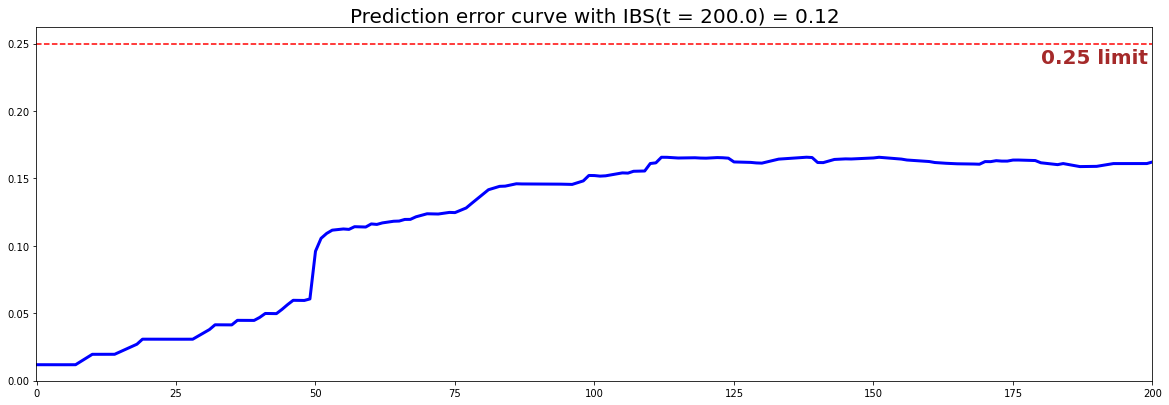

IBS: 0.1217
AUC: 0.8270


,c_index,ibs,mean_auc,model
0,0.751086,0.121738,0.826968,coxph


In [5]:
from pysurvival.models.semi_parametric import CoxPHModel
import pandas as pd

# Creating an instance of the Cox PH model and fitting the data.

## Build the model
coxph = CoxPHModel()
coxph.fit(X_train, T_train, E_train, lr=0.1, l2_reg=1e-2, init_method='zeros')

## Evaluate model
tmp_results = evaluate_model(coxph,X_train,T_train,E_train,X_test,T_test,E_test)
tmp_results['model'] = ['coxph']
results = pd.concat([results, tmp_results], ignore_index=True)
results.head()

### DeepSurv/Non-Linear CoxPH model

c-index: 0.7548


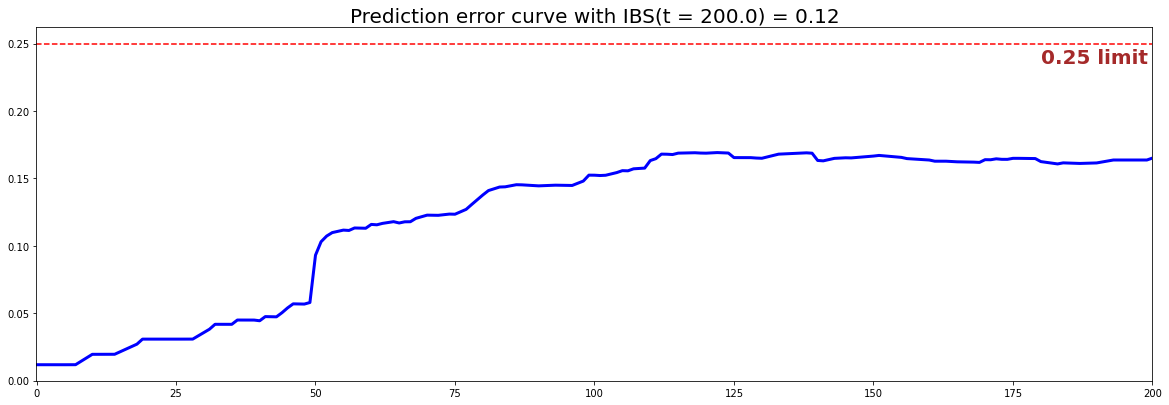

IBS: 0.1224
AUC: 0.8252


,c_index,ibs,mean_auc,model
0,0.751086,0.121738,0.826968,coxph
1,0.754814,0.122405,0.825196,nonlinear_coxph


In [6]:
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
import pandas as pd

# Creating an instance of the NonLinear CoxPH model and fitting the data.

### Defining the MLP structure. Here we will build a 1-hidden layer 
### with 150 units and `BentIdentity` as its activation function
structure = [ {'activation': 'BentIdentity', 'num_units': 150},  ]

## Build the model
nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
nonlinear_coxph.fit(X_train, T_train, E_train, lr=1e-3, init_method='xav_uniform')

## Evaluate model
tmp_results = evaluate_model(nonlinear_coxph,X_train,T_train,E_train,X_test,T_test,E_test)
tmp_results['model'] = ['nonlinear_coxph']
results = pd.concat([results, tmp_results], ignore_index=True)
results.head()

### Linear MTLR model

c-index: 0.5276


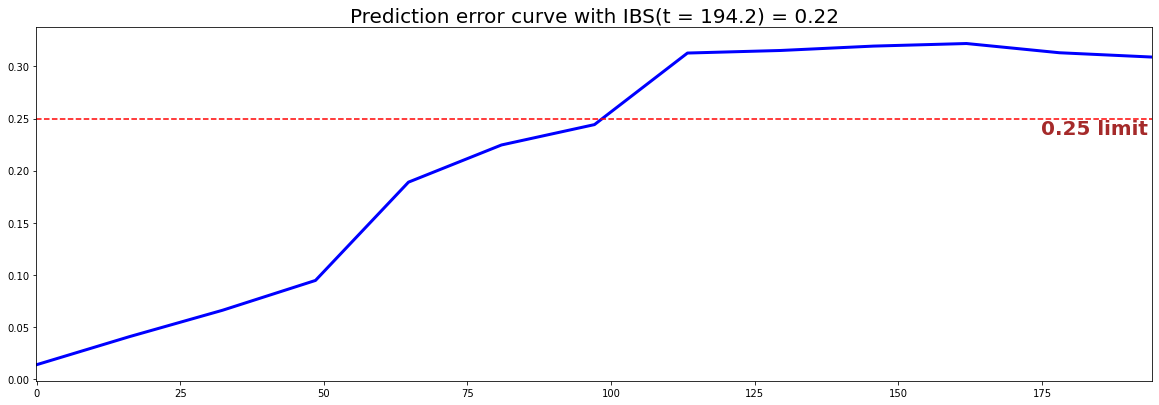

IBS: 0.2170
AUC: 0.5556


,c_index,ibs,mean_auc,model
0,0.751086,0.121738,0.826968,coxph
1,0.754814,0.122405,0.825196,nonlinear_coxph
2,0.527610,0.216992,0.555631,l_mtlr


In [7]:
from pysurvival.models.multi_task import LinearMultiTaskModel
import pandas as pd

# Creating an instance of the Linear MTLR model and fitting the data.

## Build the model
l_mtlr = LinearMultiTaskModel(bins=50)
l_mtlr.fit(X_train, T_train, E_train, lr=0.00001, l2_reg=0.001, init_method='orthogonal')

## Evaluate model
tmp_results = evaluate_model(l_mtlr,X_train,T_train,E_train,X_test,T_test,E_test)
tmp_results['model'] = ['l_mtlr']
results = pd.concat([results, tmp_results], ignore_index=True)
results.head()

### Neural MTLR model

c-index: 0.7270


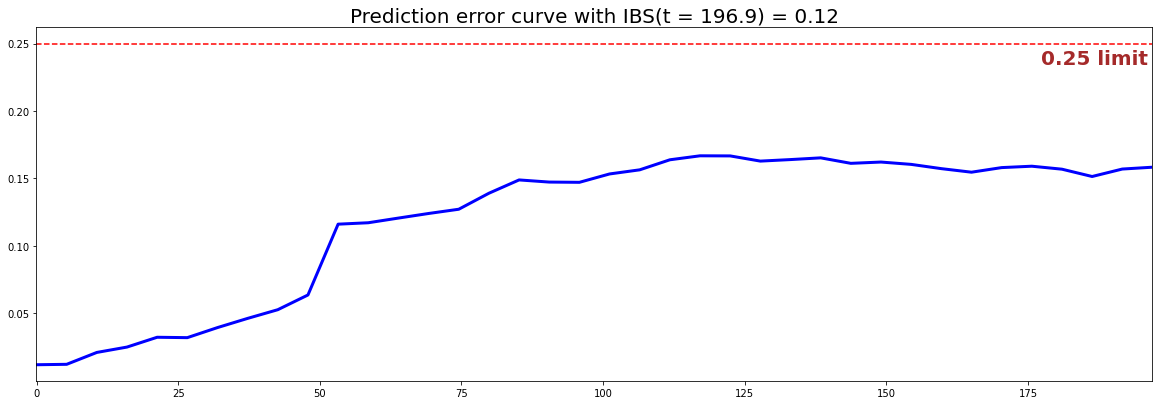

IBS: 0.1209
AUC: 0.8084


,c_index,ibs,mean_auc,model
0,0.751086,0.121738,0.826968,coxph
1,0.754814,0.122405,0.825196,nonlinear_coxph
2,0.527610,0.216992,0.555631,l_mtlr
3,0.727025,0.120935,0.808445,n_mtlr


In [8]:
from pysurvival.models.multi_task import NeuralMultiTaskModel
import pandas as pd

#### 4 - Creating an instance of the Neural MTLR model and fitting the data.

# Defining the MLP structure. Here we will build a 1-hidden layer 
# with 150 units and `Swish` as its activation function
structure = [ {'activation': 'ReLU', 'num_units': 150},  ]

# Building the model
n_mtlr = NeuralMultiTaskModel(structure=structure, bins=150)
n_mtlr.fit(X_train, T_train, E_train, 
            lr=0.00001, l2_reg=0.001, num_epochs = 500,
           init_method='orthogonal', optimizer = 'sgd')

## Evaluate model
tmp_results = evaluate_model(n_mtlr,X_train,T_train,E_train,X_test,T_test,E_test)
tmp_results['model'] = ['n_mtlr']
results = pd.concat([results, tmp_results], ignore_index=True)
results.head()

### Parametric Weibull Model

c-index: 0.6728


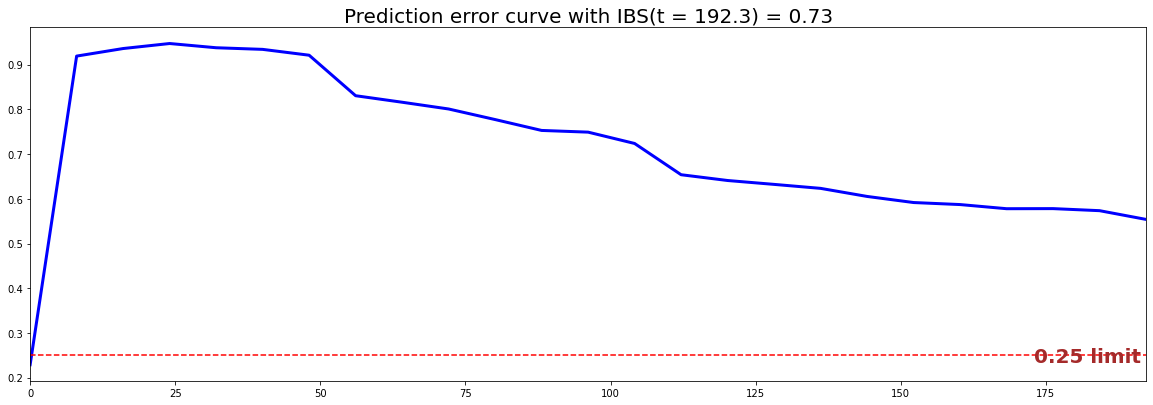

IBS: 0.7294
AUC: 0.7332


,c_index,ibs,mean_auc,model
0,0.751086,0.121738,0.826968,coxph
1,0.754814,0.122405,0.825196,nonlinear_coxph
2,0.527610,0.216992,0.555631,l_mtlr
3,0.727025,0.120935,0.808445,n_mtlr
4,0.672846,0.729390,0.733157,weib


In [9]:
from pysurvival.models.parametric import WeibullModel
import pandas as pd

# Creating an instance of the weibertz model and fitting the data.

## Build the model
weib = WeibullModel()
weib.fit(X_train, T_train, E_train, lr=0.0001, init_method='zeros',
    optimizer ='adam', l2_reg = 0.001, num_epochs=2000)

## Evaluate model
tmp_results = evaluate_model(weib,X_train,T_train,E_train,X_test,T_test,E_test)
tmp_results['model'] = ['weib']
results = pd.concat([results, tmp_results], ignore_index=True)
results.head()

### Random Survival Forest model

c-index: 0.7536


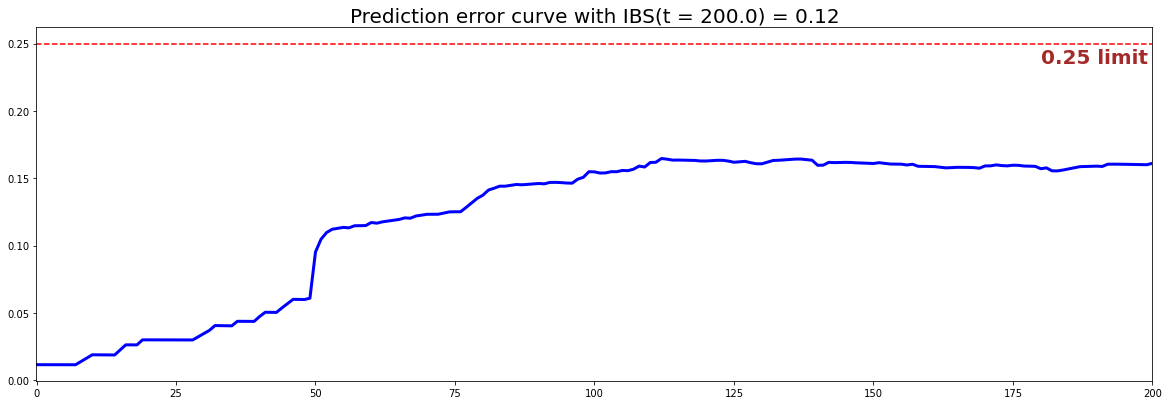

IBS: 0.1209
AUC: 0.8388


,c_index,ibs,mean_auc,model
0,0.751086,0.121738,0.826968,coxph
1,0.754814,0.122405,0.825196,nonlinear_coxph
2,0.527610,0.216992,0.555631,l_mtlr
3,0.727025,0.120935,0.808445,n_mtlr
4,0.672846,0.729390,0.733157,weib


In [10]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel
import pandas as pd

## Build the model
rsf = RandomSurvivalForestModel(num_trees=50)
rsf.fit(X_train, T_train, E_train,
        max_features="sqrt", max_depth=5, min_node_size=20)

## Evaluate model
tmp_results = evaluate_model(rsf,X_train,T_train,E_train,X_test,T_test,E_test)
tmp_results['model'] = ['rsf']
results = pd.concat([results, tmp_results], ignore_index=True)
results.head()

### Linear SVM model

In [11]:
from pysurvival.models.svm import LinearSVMModel
import pandas as pd

# Creating an instance of the Linear SVM model and fitting the data.
## Build Model
svm_l = LinearSVMModel()
svm_l.fit(X_train, T_train, E_train, init_method='he_uniform',
    with_bias = True, lr = 0.5,  tol = 1e-3,  l2_reg = 1e-3)

## Evaluate model
tmp_results = evaluate_model(svm_l,X_train,T_train,E_train,X_test,T_test,E_test,ibs=False)
tmp_results['model'] = ['svm_l']
results = pd.concat([results, tmp_results], ignore_index=True)
results.head()

Performing Newton-Raphson optimization: 
 * Iteration #1 - Loss = 8398.174 - ||grad||^2 = 12434.67353 - ||diff_w|| = 20.76762
 * Iteration #2 - Loss = 2157.578 - ||grad||^2 = 6367.52544 - ||diff_w|| = 9.31410
 * Iteration #3 - Loss = 683.431 - ||grad||^2 = 3612.19122 - ||diff_w|| = 5.05639
 * Iteration #4 - Loss = 230.443 - ||grad||^2 = 2003.26608 - ||diff_w|| = 2.60201
 * Iteration #5 - Loss = 102.173 - ||grad||^2 = 1001.36599 - ||diff_w|| = 1.14542
 * Iteration #6 - Loss = 73.959 - ||grad||^2 = 524.38782 - ||diff_w|| = 0.55526
 * Iteration #7 - Loss = 68.320 - ||grad||^2 = 263.41298 - ||diff_w|| = 0.29407
 * Iteration #8 - Loss = 67.745 - ||grad||^2 = 114.74788 - ||diff_w|| = 0.15193
 * Iteration #9 - Loss = 67.821 - ||grad||^2 = 47.32889 - ||diff_w|| = 0.07620
 * Iteration #10 - Loss = 67.869 - ||grad||^2 = 20.07897 - ||diff_w|| = 0.03868
 * Iteration #11 - Loss = 67.876 - ||grad||^2 = 8.99888 - ||diff_w|| = 0.01988
 * Iteration #12 - Loss = 67.877 - ||grad||^2 = 4.22015 - ||diff_w|

,c_index,ibs,mean_auc,model
0,0.751086,0.121738,0.826968,coxph
1,0.754814,0.122405,0.825196,nonlinear_coxph
2,0.527610,0.216992,0.555631,l_mtlr
3,0.727025,0.120935,0.808445,n_mtlr
4,0.672846,0.729390,0.733157,weib


### Evaluate Results

In [14]:
# Show results table

results.round(2).head(10)

,c_index,ibs,mean_auc,model
0,0.75,0.12,0.83,coxph
1,0.75,0.12,0.83,nonlinear_coxph
2,0.53,0.22,0.56,l_mtlr
3,0.73,0.12,0.81,n_mtlr
4,0.67,0.73,0.73,weib
5,0.75,0.12,0.84,rsf
6,0.76,1.00,0.17,svm_l


In [13]:
print('max c_index is on line:{}'.format(results['c_index'].idxmax()))
print('max mean_auc is on line:{}'.format(results['mean_auc'].idxmax()))
print('min ibs is on line:{}'.format(results['ibs'].idxmin()))

max c_index is on line:6
max mean_auc is on line:5
min ibs is on line:5
